In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf

In [3]:
import threading
import os
import cPickle as pickle
import logging
import pprint
import glob
import collections
import struct
import json
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=logging.INFO)


In [4]:
logging.info('abc')

08/15/2017 09:27:43 PM INFO: abc


In [5]:
class GeneratorRunner(object):
    "Custom runner that that runs an generator in a thread and enqueues the outputs."

    def __init__(self, generator, placeholders, enqueue_op, close_op):
        self._generator = generator
        self._placeholders = placeholders
        self._enqueue_op = enqueue_op
        self._close_op = close_op

    def _run(self, sess, coord):
        try:
            while not coord.should_stop():
                try:
                    values = next(self._generator)

                    assert len(values) == len(self._placeholders), \
                        'generator values and placeholders must have the same length'

                    feed_dict = {placeholder: value \
                        for placeholder, value in zip(self._placeholders, values)}
                    sess.run(self._enqueue_op, feed_dict=feed_dict)
                except (StopIteration, tf.errors.OutOfRangeError, tf.errors.DeadlineExceededError, tf.errors.CancelledError) as e:
                    logging.warning ("%s %s %s", self.__class__.__name__, "exception:", str(type(e)))
                    try:
                        sess.run(self._close_op)
                    except Exception:
                        pass
                    return
        except Exception as ex:
            if coord:
                logging.info ("%s %s %s %s", self.__class__.__name__, "request stop from", self._run.__name__, str(ex))
                coord.request_stop(ex)
                pass
            else: 
                raise

    def create_threads(self, sess, coord=None, daemon=False, start=False):
        "Called by `start_queue_runners`."

        thread = threading.Thread(
            target=self._run,
            args=(sess, coord))

        if coord:
            coord.register_thread(thread)

        if daemon:
            thread.daemon = True

        if start:
            thread.start()

        return [thread]

def read_batch_generator(
        generator, dtypes, shapes, batch_size,
        queue_capacity=10000,
        allow_smaller_final_batch=False):
    "Reads values from an generator, queues, and batches."

    assert len(dtypes) == len(shapes), 'dtypes and shapes must have the same length'
    logging.info('shapes: %s, types: %s, batchsize: %d', str(shapes), str(dtypes), batch_size)
    queue = tf.FIFOQueue(
        capacity=queue_capacity,
        dtypes=dtypes,
        shapes=shapes)

    placeholders = [tf.placeholder(dtype, shape) for dtype, shape in zip(dtypes, shapes)]

    enqueue_op = queue.enqueue(placeholders)
    close_op = queue.close(cancel_pending_enqueues=True)
    global_close_ops.append(close_op)
    queue_runner = GeneratorRunner(generator, placeholders, enqueue_op, close_op)
    tf.train.add_queue_runner(queue_runner)

    if allow_smaller_final_batch:
        return queue.dequeue_up_to(batch_size)
    else:
        return queue.dequeue_many(batch_size)    

In [6]:
LEN1=64*2
import Queue
class MemoryGenerator(object):
    def __init__(self, daily_data,attrib_data, epochs=np.inf):
        self.daily_data = daily_data
        self.attrib_data = attrib_data        
        self.shuffle=True
        self.epochs = epochs
        self.N = len(self.daily_data)*10
        self.curr_epoch = 1
        self.curr_i = 0
        self.q = Queue.Queue()
        if self.shuffle:
            self.do_shuffle()
    def __iter__(self):
        return self
    def do_shuffle(self):
        idx = np.random.permutation(range(len(self.daily_data)))
        self.daily_data = self.daily_data[idx]     
        self.attrib_data = self.attrib_data[idx]
    def fill_queue(self):
        for _ in range(100):
            i=int(np.random.random()*len(self.daily_data))
            attrib_row=self.attrib_data[i]
            row=self.daily_data[i]
            len1=LEN1
            len2=60
            j=int(np.random.random()*(len(row)-1))
            part_x=row[:j]
            if len(part_x)>=len1:
                x=part_x[len(part_x)-len1:]
            else:
                x=np.zeros(len1,dtype=np.float32)
                x[len1-len(part_x):]=part_x
            part_y=row[j:j+len2]
            y=np.zeros(len2,dtype=np.float32)
            y[:len(part_y)]=part_y
            mask=np.zeros(len2,dtype=np.float32)
            mask[:len(part_y)]= (part_y!=0)*1
            self.q.put((x.astype(np.float32),attrib_row.astype(np.float32),np.array(y,dtype=np.float32),mask))
    def __next__(self):
        return self.next()
    def next(self):
        if self.curr_i >= self.N:
            self.curr_i = 0
            self.curr_epoch += 1
            if self.curr_epoch > self.epochs: raise StopIteration
            if self.shuffle: 
                self.do_shuffle()
        if self.q.empty(): self.fill_queue()
        X1,X2, y,mask = self.q.get()
        self.curr_i += 1
        return X1,X2, y,mask 


In [7]:
def make_train_readers(daily_data,attrib_data, nrows=None, batchsize=60):
    print daily_data.shape, attrib_data.shape
    train_generator = MemoryGenerator(daily_data,attrib_data)
    return read_batch_generator(train_generator, [tf.float32, tf.float32, tf.float32, tf.float32], 
                                [(LEN1,), (12,), (60,),(60,)], batchsize, allow_smaller_final_batch=True),train_generator

In [3]:
locales=sorted([u'en', u'ja', u'de', u'fr', u'zh', u'ru', u'es'])
locale_map={v:u for u,v in enumerate(locales)}
locale_map

{u'de': 0, u'en': 1, u'es': 2, u'fr': 3, u'ja': 4, u'ru': 5, u'zh': 6}

In [4]:
access_map={u'all-access':0, u'mobile-web':1, u'desktop':2}
agent_map={u'all-agents':0, u'spider':1}
access_map,agent_map

({u'all-access': 0, u'desktop': 2, u'mobile-web': 1},
 {u'all-agents': 0, u'spider': 1})

In [5]:
def f_map(series, data_map):
    lst=[]
    keys=list(data_map.keys())
    for k in keys:
        lst.append(series.map(lambda u: (u==k)*1))
    df=pd.concat(lst,axis=1)
    df.columns=[series.name+"_"+u for u in keys]
    return df

In [11]:
def make_data():
    import pandas as pd
    csv_path="../input/newtrain_1.csv"
    data = pd.read_csv(csv_path, nrows=None)
    datecols=[u for u in data.columns if u.startswith("20")][-256:]
    daily_data=data[datecols].values.astype(np.float32)
    attrib_data=pd.concat([f_map(data.locale,locale_map),
                           f_map(data.agent,agent_map),
                           f_map(data.access,access_map)],axis=1).values.astype(np.float32)    
    print daily_data.shape,attrib_data.shape
    return daily_data,attrib_data

In [12]:
daily_data,attrib_data=make_data()

(145063, 256) (145063, 12)


In [13]:
print np.mean(daily_data==0)
#daily_data += (daily_data==0)*0.1
#print np.mean(daily_data==0)

0.0564550240671


In [14]:
if 0:
    global_close_ops = []
    #daily_data,attrib_data=make_data()
    _, generator=make_train_readers(daily_data,attrib_data)
    a,b,c,d= generator.next()
    #print a,b,c,d    
    print a.shape,b.shape,c.shape,d.shape


In [15]:
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>" % size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    from IPython.display import clear_output, Image, display, HTML

    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))


In [16]:
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def dense(x, size, scope, with_activation=True):
    if 1:
        with tf.variable_scope(scope):
            w = weight_variable(shape=[int(x.get_shape()[-1]), size], name=None)
            b = bias_variable(shape=[size], name=None)
            h1 = tf.matmul(x, w) + b
            layer=tf.sigmoid(h1) if with_activation else h1
            print layer.get_shape()
    return layer,w,b
from tensorflow.contrib import rnn
def lstm(x,x2, n_hiddens, n_input, n_output, scope):
    if 1:
        with tf.variable_scope(scope):
            x = tf.reshape(x, [-1, n_input])
            x = tf.split(x,n_input,1)
            basic_rnn_cells = [rnn.BasicLSTMCell(n_hidden) for n_hidden in n_hiddens]
            rnn_cell = rnn.MultiRNNCell(basic_rnn_cells)
            outputs, states = rnn.static_rnn(rnn_cell, x, dtype=tf.float32) 
            concat_x=tf.concat([outputs[-1],x2],-1)
            print outputs[-1].get_shape(), concat_x.get_shape()             
            return concat_x

def get_Xy(x_size,x2_size,y_size):
    X = tf.placeholder("float", shape=[None, x_size], name='input_x')
    X2 = tf.placeholder("float", shape=[None, x2_size], name='input_x2')    
    l2_scale = tf.placeholder(tf.float32, name='l2_scale')
    y = tf.placeholder("float", shape=[None, y_size], name='input_y')
    mask = tf.placeholder("float", shape=[None, y_size], name='mask')
    return X,X2, y,mask, l2_scale

In [17]:
class MyModel(object):
    def __init__(self, x_size,y_size, n_hiddens,l2_scale,phase=True ):
        self.phase=phase
        n_hiddens=n_hiddens
        self.graph = tf.Graph()
        self.all_denses = []
        with self.graph.as_default(): 
            self.X, self.X2, self.y, self.mask, self.l2_scale = get_Xy(x_size,12, y_size)
            assert(x_size == self.X.get_shape()[1])
            with tf.variable_scope("nodes"):
                self.X, self.y, self.loss, self.smape \
                     = self.make_model(x_size=x_size, y_size=y_size, n_hiddens=n_hiddens)

            
            with tf.variable_scope('saver'):
                    self.saver = tf.train.Saver()

            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.variable_scope('optimizer'):
                with tf.control_dependencies(update_ops):
                    self.optimizer = tf.train.AdamOptimizer()#.minimize(self.loss)
                    gvs = self.optimizer.compute_gradients(self.loss)
                    capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
                    self.train_op = self.optimizer.apply_gradients(capped_gvs)
        self._session = None    
    @property
    def session(self): 
        if self._session is None:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
            self._session = tf.Session(graph=self.graph,config=config)
        return self._session
    
    def close_session(self):
        if self._session is not None:
            self._session.close()
            self._session = None
    def initialize(self, session=None):
        with self.graph.as_default():
            init_op = tf.global_variables_initializer()        
        self.session.run(init_op) 
        return self.session
 
        
    def make_model(self, x_size,y_size, n_hiddens):
        X_raw, y  = self.X, self.y 
        logging.debug ("%s %s", self.__class__.__name__,
                       'input shapes: X={},y={}'.format(X_raw.get_shape(), None if y is None else y.get_shape()))

        h = tf.log(X_raw+1)
        #h=     tf.layers.batch_normalization(h,center=False, scale=True,training=self.phase)
        
        h=lstm(h,self.X2, [n_hiddens[0]], x_size, y_size, 'lstm')
        for i in range(0, len(n_hiddens)):
            n_hidden = n_hiddens[i]
            h, w,b = dense(h, n_hidden,'dense')
            self.all_denses.append((h,w,b))

        logits_sum,_,_=dense(h,y_size,'dense',with_activation=False)
        
        with tf.variable_scope("loss"):
            epsilon = 1e-7        
            l2_loss = 0
            if 1:  # self.l2_scale > 0:
                logging.info('use l2 reg scale %s', str(self.l2_scale))
                for _,w,_ in self.all_denses:
                    l2_loss = l2_loss + tf.reduce_sum(w ** 2)
                l2_loss = l2_loss * self.l2_scale
                self.l2_loss = l2_loss
            if 1:
                predictions = tf.identity(logits_sum, name='prediction')
                float_labels = tf.cast(y, tf.float32)
                
                ratio=predictions/(float_labels+1e-4)
                additional_loss= 0.02*tf.cast(ratio>9,tf.float32)*tf.abs(ratio)\
                    +0.02*tf.cast(predictions<0.0,tf.float32)*tf.abs(predictions)
                additional_loss = tf.reduce_sum(additional_loss*self.mask)/tf.reduce_sum(self.mask)
                this_loss =  tf.abs(predictions-float_labels)/(tf.abs(predictions)+tf.abs(float_labels))
                this_loss=this_loss*self.mask
                this_loss = tf.identity(2* tf.reduce_sum(this_loss)/tf.reduce_sum(self.mask), name='smape')                          
                loss = this_loss + l2_loss+additional_loss

            logging.info ('%s %s %s', self.__class__.__name__, 'logits shape', logits_sum.get_shape())

        return X_raw, y, loss, this_loss
 
    
    def save(self, prefix, ckpt=1):
        checkpoint_name = '{}/model_{}'.format(prefix, 0)
        self.saver.save(self.session, checkpoint_name, global_step=ckpt)

    def load(self, prefix, ckpt=1):
        self.saver.restore(self.session, '{}/model_{}-{}'.format(prefix, self.model_id, ckpt))


In [18]:
if 0:
    tf.reset_default_graph()
    model = MyModel(x_size=5, y_size=2, n_hiddens=[2,2], l2_scale=0.1)
    model.initialize()
    #print [n.op for n in model.graph.as_graph_def().node];
    show_graph(model.graph.as_graph_def())

In [19]:
def svd_orthonormal(shape):
    print(shape)
    if len(shape) < 2:
        raise RuntimeError("Only shapes of length 2 or more are supported.")
    flat_shape = (shape[0], np.prod(shape[1:]))
    a = np.random.standard_normal(flat_shape)
    u, _, v = np.linalg.svd(a, full_matrices=False)
    q = u if u.shape == flat_shape else v
    q = q.reshape(shape)
    return q

def get_activations(model, h, X_batch):
    activations = model.session.run(h, feed_dict={model.X:X_batch})
    return activations

def LSUVinit(model, batch):
    # only these layer classes considered for LSUV initialization; add more if needed    
    margin = 0.1
    max_iter = 10
    layers_inintialized = 0
    for h,w,_ in model.all_denses:
        # avoid small layers where activation variance close to zero, esp. for small batches
        if np.prod(h.get_shape()) < 32:
            print(h, 'too small')
            continue
        logging.info('LSUV initializing' + str(h))
        layers_inintialized += 1
        needed_variance = 1.0
        
        # print ('pre',np.sum(model.session.run(np.abs(w))))
        weights = svd_orthonormal(w.get_shape())
        model.session.run(tf.assign(w, weights))
        # print (model.session.run(w),weights)
        # print ('post',np.sum(model.session.run(np.abs(w))),np.sum(np.abs(weights)))        
        acts1 = get_activations(model, h, batch)
        # print (acts1,needed_variance)
        
        var1 = np.var(acts1)
        iter1 = 0
        logging.info('var1 %f', var1)
        while (abs(needed_variance - var1) > margin):
            if np.abs(np.sqrt(var1)) < 1e-7: break  # avoid zero division
            weights /= np.sqrt(var1) / np.sqrt(needed_variance)
            model.session.run(tf.assign(w, weights))
            acts1 = get_activations(model, h, batch)
            var1 = np.var(acts1)
            iter1 += 1
            # print (acts1)
            logging.info('var1 %f', var1)
            if iter1 > max_iter:
                break
    logging.info('LSUV: total layers initialized %d', layers_inintialized)   
    return model


In [20]:

class BN(object):
    def __init__(self, x_size, y_size, n_hiddens, l2_scale=0.0, prefix='./tmp'):
        self.x_size = x_size
        self.y_size=y_size
        self.n_hiddens = n_hiddens
        self.l2_scale = l2_scale
        self.prefix = prefix
    

    def train_one_epoch(self, n_epoch, sess, model, train_reader,test_reader, coord):
        count = 0
        loss = []; l2_loss = []
        while not coord.should_stop():
            try:
                if  True:
                    X,X2, y,mask = sess.run(train_reader)
                    feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                    _, a, aa = model.session.run([model.train_op, model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                    loss.append(a)
                    l2_loss.append(aa)
                    count += len(y)
                    if count % self.net_train_report_intev == 0:

                        logging.info ('[epoch {}][step {}] AVG LOSS: {}, smape: {}'.format(
                            n_epoch, count, np.mean(loss), np.mean(l2_loss)))
                        loss = []; l2_loss = []
                        #self.read_params()

                    if count >= self.net_train_eval_intev:
                        X,X2, y,mask = sess.run(test_reader)
                        feed_dict = {model.X:X, model.X2:X2, model.y:y, model.mask:mask, model.l2_scale: self.l2_scale}
                        a, aa = model.session.run([ model.loss, model.smape], 
                                                    feed_dict=feed_dict)
                        logging.info ('[epoch {}] Valid LOSS: {}, smape: {}'.format(
                            n_epoch, a, aa))
                        return 0
            except tf.errors.OutOfRangeError:
                logging.info (self.__class__.__name__, 'Done with read')
                logging.info (self.__class__.__name__, "request stop from", self.train_one_epoch.__name__)                
                coord.request_stop()
                for o in global_close_ops: sess.run(o)
                return 1                                      
            except:
                raise           
        return 0


    def save_net(self, sess, model, n_epoch):
        model.save(prefix=self.prefix, ckpt=n_epoch)

    def train(self, daily_data,attrib_data, net_round,net_train_report_intev,net_train_eval_intev):
        self.net_train_report_intev=net_train_report_intev
        self.net_train_eval_intev=net_train_eval_intev
        model = MyModel(x_size=self.x_size, y_size=self.y_size, n_hiddens=self.n_hiddens,
                             l2_scale=self.l2_scale)
        model.initialize()
        config = tf.ConfigProto(log_device_placement=True)
        config.gpu_options.per_process_gpu_memory_fraction = 0.5  # don't hog all vRAM
        # config.operation_timeout_in_ms = 10000  # terminate on long hangs
        idx=np.random.permutation(range(len(daily_data)))
        trainidx=idx[:int(len(idx)*0.8)]
        testidx=idx[int(len(idx)*0.8):]
        train_daily_data=daily_data[trainidx]
        train_attrib_data=attrib_data[trainidx]
        test_daily_data=daily_data[testidx]
        test_attrib_data=attrib_data[testidx] 
        print train_daily_data.shape,test_daily_data.shape
        with tf.Session(config=config) as sess:
            train_reader,_ = make_train_readers(train_daily_data,train_attrib_data,batchsize=batch_size,nrows=None)            
            test_reader,_ = make_train_readers(test_daily_data,test_attrib_data,batchsize=batch_size*20,nrows=None)            
            
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(sess=sess, coord=coord)
            res = None
            try:
                if 0:
                    logging.info('Use LSUV initialization')
                    batch = np.concatenate([sess.run(train_reader)[0] for _ in range(100)])
                    LSUVinit(model, batch)
                for j in range(net_round):
                    logging.info ('[epoch {}] start net training'.format(j))
                    if self.train_one_epoch(j, sess, model, train_reader, test_reader,coord) is None:
                        raise Exception("train error") 
                    self.save_net(sess=sess, model=model, n_epoch=0)
            except:
                raise 
            finally:
                logging.info ('%s %s %s', self.__class__.__name__, "request stop from", self.train.__name__)
                for o in global_close_ops: sess.run(o)                
                coord.request_stop()

            coord.join(threads)
            sess.close()
            model.close_session()
            return 

    def read_params(self):
	try:
	    with open('param.txt') as f:
	        m = json.load(f)
 	    a = m["l2_scale"]
	    if self.l2_scale != a: 
		logging.info("Change l2_scale from %e to %e", self.l2_scale, a)
	     	self.l2_scale = a
	except:
	    logging.error('read params failed')


In [21]:
daily_data.shape

(145063, 256)

In [22]:
l2_scale = 1e-8*0

batch_size = 256

if 0: #test
    n_hiddens=[10]
    net_round=10
    net_train_report_intev=batch_size*10
    net_train_eval_intev=10000
else:
    n_hiddens=[512,512]    
    net_round=200
    net_train_report_intev=batch_size*100
    net_train_eval_intev=batch_size*1000

In [23]:
global_close_ops = []
tf.reset_default_graph()       
model = BN(x_size=LEN1, y_size=60, n_hiddens=n_hiddens, prefix='tmp_pred60_lstm_512_256d_nozero', l2_scale=l2_scale)
model.train(daily_data,attrib_data,  \
           net_round=net_round,  net_train_report_intev=net_train_report_intev,
            net_train_eval_intev=net_train_eval_intev )  

08/15/2017 05:10:23 AM INFO: use l2 reg scale Tensor("l2_scale:0", dtype=float32)
08/15/2017 05:10:23 AM INFO: MyModel logits shape (?, 60)


(?, 512) (?, 524)
(?, 512)
(?, 512)
(?, 60)


08/15/2017 05:10:35 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 256
08/15/2017 05:10:35 AM INFO: shapes: [(128,), (12,), (60,), (60,)], types: [tf.float32, tf.float32, tf.float32, tf.float32], batchsize: 5120
08/15/2017 05:10:35 AM INFO: [epoch 0] start net training


(116050, 256) (29013, 256)
(116050, 256) (116050, 12)
(29013, 256) (29013, 12)


08/15/2017 05:11:01 AM INFO: [epoch 0][step 25600] AVG LOSS: 1.48116314411, smape: 1.47573840618
08/15/2017 05:11:21 AM INFO: [epoch 0][step 51200] AVG LOSS: 1.3948892355, smape: 1.37842297554
08/15/2017 05:11:41 AM INFO: [epoch 0][step 76800] AVG LOSS: 1.38377273083, smape: 1.35734117031
08/15/2017 05:12:01 AM INFO: [epoch 0][step 102400] AVG LOSS: 1.37123322487, smape: 1.335298419
08/15/2017 05:12:22 AM INFO: [epoch 0][step 128000] AVG LOSS: 1.37592351437, smape: 1.33304870129
08/15/2017 05:12:42 AM INFO: [epoch 0][step 153600] AVG LOSS: 1.36492919922, smape: 1.31471395493
08/15/2017 05:13:02 AM INFO: [epoch 0][step 179200] AVG LOSS: 1.36694645882, smape: 1.30939328671
08/15/2017 05:13:23 AM INFO: [epoch 0][step 204800] AVG LOSS: 1.36159038544, smape: 1.30072259903
08/15/2017 05:13:43 AM INFO: [epoch 0][step 230400] AVG LOSS: 1.35719013214, smape: 1.29303216934
08/15/2017 05:14:03 AM INFO: [epoch 0][step 256000] AVG LOSS: 1.36736965179, smape: 1.29696536064
08/15/2017 05:14:05 AM INF

08/15/2017 05:36:19 AM INFO: [epoch 7][step 102400] AVG LOSS: 0.493530809879, smape: 0.491383701563
08/15/2017 05:36:40 AM INFO: [epoch 7][step 128000] AVG LOSS: 0.491447627544, smape: 0.489113241434
08/15/2017 05:37:01 AM INFO: [epoch 7][step 153600] AVG LOSS: 0.490487754345, smape: 0.488285720348
08/15/2017 05:37:21 AM INFO: [epoch 7][step 179200] AVG LOSS: 0.488474488258, smape: 0.486473321915
08/15/2017 05:37:42 AM INFO: [epoch 7][step 204800] AVG LOSS: 0.488007515669, smape: 0.485457509756
08/15/2017 05:38:02 AM INFO: [epoch 7][step 230400] AVG LOSS: 0.489436745644, smape: 0.486246943474
08/15/2017 05:38:23 AM INFO: [epoch 7][step 256000] AVG LOSS: 0.492400616407, smape: 0.489883452654
08/15/2017 05:38:24 AM INFO: [epoch 7] Valid LOSS: 0.490498304367, smape: 0.488913744688
08/15/2017 05:38:26 AM INFO: [epoch 8] start net training
08/15/2017 05:38:46 AM INFO: [epoch 8][step 25600] AVG LOSS: 0.488410979509, smape: 0.486933946609
08/15/2017 05:39:07 AM INFO: [epoch 8][step 51200] AVG

08/15/2017 06:01:20 AM INFO: [epoch 14][step 153600] AVG LOSS: 0.437955498695, smape: 0.435971826315
08/15/2017 06:01:41 AM INFO: [epoch 14][step 179200] AVG LOSS: 0.441427648067, smape: 0.438476383686
08/15/2017 06:02:02 AM INFO: [epoch 14][step 204800] AVG LOSS: 0.43929412961, smape: 0.436758816242
08/15/2017 06:02:22 AM INFO: [epoch 14][step 230400] AVG LOSS: 0.439069569111, smape: 0.437128216028
08/15/2017 06:02:43 AM INFO: [epoch 14][step 256000] AVG LOSS: 0.440840572119, smape: 0.438278973103
08/15/2017 06:02:44 AM INFO: [epoch 14] Valid LOSS: 0.433664858341, smape: 0.432026863098
08/15/2017 06:02:45 AM INFO: [epoch 15] start net training
08/15/2017 06:03:06 AM INFO: [epoch 15][step 25600] AVG LOSS: 0.43884280324, smape: 0.435868263245
08/15/2017 06:03:27 AM INFO: [epoch 15][step 51200] AVG LOSS: 0.443523108959, smape: 0.439560770988
08/15/2017 06:03:47 AM INFO: [epoch 15][step 76800] AVG LOSS: 0.442940026522, smape: 0.440109163523
08/15/2017 06:04:08 AM INFO: [epoch 15][step 102

08/15/2017 06:26:22 AM INFO: [epoch 21][step 204800] AVG LOSS: 0.423605054617, smape: 0.42089164257
08/15/2017 06:26:42 AM INFO: [epoch 21][step 230400] AVG LOSS: 0.423748582602, smape: 0.421504855156
08/15/2017 06:27:03 AM INFO: [epoch 21][step 256000] AVG LOSS: 0.424430847168, smape: 0.422535061836
08/15/2017 06:27:04 AM INFO: [epoch 21] Valid LOSS: 0.421169936657, smape: 0.419586479664
08/15/2017 06:27:05 AM INFO: [epoch 22] start net training
08/15/2017 06:27:26 AM INFO: [epoch 22][step 25600] AVG LOSS: 0.423375815153, smape: 0.421114504337
08/15/2017 06:27:47 AM INFO: [epoch 22][step 51200] AVG LOSS: 0.425385862589, smape: 0.422778785229
08/15/2017 06:28:07 AM INFO: [epoch 22][step 76800] AVG LOSS: 0.427734136581, smape: 0.425299793482
08/15/2017 06:28:28 AM INFO: [epoch 22][step 102400] AVG LOSS: 0.428034901619, smape: 0.424656271935
08/15/2017 06:28:49 AM INFO: [epoch 22][step 128000] AVG LOSS: 0.422370135784, smape: 0.419852554798
08/15/2017 06:29:09 AM INFO: [epoch 22][step 15

08/15/2017 06:51:24 AM INFO: [epoch 28][step 256000] AVG LOSS: 0.417352318764, smape: 0.415550738573
08/15/2017 06:51:25 AM INFO: [epoch 28] Valid LOSS: 0.413805037737, smape: 0.412498772144
08/15/2017 06:51:26 AM INFO: [epoch 29] start net training
08/15/2017 06:51:47 AM INFO: [epoch 29][step 25600] AVG LOSS: 0.416732877493, smape: 0.414601176977
08/15/2017 06:52:08 AM INFO: [epoch 29][step 51200] AVG LOSS: 0.421365141869, smape: 0.418703734875
08/15/2017 06:52:28 AM INFO: [epoch 29][step 76800] AVG LOSS: 0.418025404215, smape: 0.415946155787
08/15/2017 06:52:49 AM INFO: [epoch 29][step 102400] AVG LOSS: 0.419257253408, smape: 0.417272597551
08/15/2017 06:53:10 AM INFO: [epoch 29][step 128000] AVG LOSS: 0.415352910757, smape: 0.413475483656
08/15/2017 06:53:30 AM INFO: [epoch 29][step 153600] AVG LOSS: 0.417898446321, smape: 0.41517573595
08/15/2017 06:53:51 AM INFO: [epoch 29][step 179200] AVG LOSS: 0.417040973902, smape: 0.414765864611
08/15/2017 06:54:12 AM INFO: [epoch 29][step 20

08/15/2017 07:15:47 AM INFO: [epoch 36] start net training
08/15/2017 07:16:08 AM INFO: [epoch 36][step 25600] AVG LOSS: 0.413382083178, smape: 0.411377072334
08/15/2017 07:16:28 AM INFO: [epoch 36][step 51200] AVG LOSS: 0.409693807364, smape: 0.407928228378
08/15/2017 07:16:49 AM INFO: [epoch 36][step 76800] AVG LOSS: 0.413919955492, smape: 0.412168383598
08/15/2017 07:17:10 AM INFO: [epoch 36][step 102400] AVG LOSS: 0.413228601217, smape: 0.41141846776
08/15/2017 07:17:30 AM INFO: [epoch 36][step 128000] AVG LOSS: 0.409800082445, smape: 0.407465785742
08/15/2017 07:17:51 AM INFO: [epoch 36][step 153600] AVG LOSS: 0.41244083643, smape: 0.410752803087
08/15/2017 07:18:12 AM INFO: [epoch 36][step 179200] AVG LOSS: 0.414570838213, smape: 0.412439197302
08/15/2017 07:18:32 AM INFO: [epoch 36][step 204800] AVG LOSS: 0.414648622274, smape: 0.412666767836
08/15/2017 07:18:53 AM INFO: [epoch 36][step 230400] AVG LOSS: 0.407501131296, smape: 0.405618309975
08/15/2017 07:19:14 AM INFO: [epoch 3

08/15/2017 07:40:50 AM INFO: [epoch 43][step 51200] AVG LOSS: 0.404339760542, smape: 0.402269124985
08/15/2017 07:41:11 AM INFO: [epoch 43][step 76800] AVG LOSS: 0.404721409082, smape: 0.402735948563
08/15/2017 07:41:32 AM INFO: [epoch 43][step 102400] AVG LOSS: 0.407641321421, smape: 0.405481606722
08/15/2017 07:41:52 AM INFO: [epoch 43][step 128000] AVG LOSS: 0.402149200439, smape: 0.400997400284
08/15/2017 07:42:13 AM INFO: [epoch 43][step 153600] AVG LOSS: 0.407476603985, smape: 0.405821561813
08/15/2017 07:42:34 AM INFO: [epoch 43][step 179200] AVG LOSS: 0.403415560722, smape: 0.401199609041
08/15/2017 07:42:54 AM INFO: [epoch 43][step 204800] AVG LOSS: 0.405506581068, smape: 0.403818130493
08/15/2017 07:43:15 AM INFO: [epoch 43][step 230400] AVG LOSS: 0.403483003378, smape: 0.401085704565
08/15/2017 07:43:35 AM INFO: [epoch 43][step 256000] AVG LOSS: 0.404090285301, smape: 0.402041018009
08/15/2017 07:43:37 AM INFO: [epoch 43] Valid LOSS: 0.400660842657, smape: 0.399227797985
08/

08/15/2017 08:05:52 AM INFO: [epoch 50][step 102400] AVG LOSS: 0.400899022818, smape: 0.399101376534
08/15/2017 08:06:13 AM INFO: [epoch 50][step 128000] AVG LOSS: 0.402127027512, smape: 0.400258421898
08/15/2017 08:06:33 AM INFO: [epoch 50][step 153600] AVG LOSS: 0.399572014809, smape: 0.398126244545
08/15/2017 08:06:54 AM INFO: [epoch 50][step 179200] AVG LOSS: 0.400861471891, smape: 0.399159818888
08/15/2017 08:07:15 AM INFO: [epoch 50][step 204800] AVG LOSS: 0.401368707418, smape: 0.399494349957
08/15/2017 08:07:35 AM INFO: [epoch 50][step 230400] AVG LOSS: 0.400744736195, smape: 0.399004071951
08/15/2017 08:07:56 AM INFO: [epoch 50][step 256000] AVG LOSS: 0.402688533068, smape: 0.400786489248
08/15/2017 08:07:57 AM INFO: [epoch 50] Valid LOSS: 0.40328347683, smape: 0.400983482599
08/15/2017 08:07:59 AM INFO: [epoch 51] start net training
08/15/2017 08:08:20 AM INFO: [epoch 51][step 25600] AVG LOSS: 0.403387933969, smape: 0.401528656483
08/15/2017 08:08:40 AM INFO: [epoch 51][step 

08/15/2017 08:30:54 AM INFO: [epoch 57][step 153600] AVG LOSS: 0.39843967557, smape: 0.396304309368
08/15/2017 08:31:14 AM INFO: [epoch 57][step 179200] AVG LOSS: 0.399291217327, smape: 0.396341621876
08/15/2017 08:31:35 AM INFO: [epoch 57][step 204800] AVG LOSS: 0.400922596455, smape: 0.399239420891
08/15/2017 08:31:56 AM INFO: [epoch 57][step 230400] AVG LOSS: 0.398772597313, smape: 0.397462397814
08/15/2017 08:32:16 AM INFO: [epoch 57][step 256000] AVG LOSS: 0.395308613777, smape: 0.393772125244
08/15/2017 08:32:17 AM INFO: [epoch 57] Valid LOSS: 0.401328414679, smape: 0.399073421955
08/15/2017 08:32:19 AM INFO: [epoch 58] start net training
08/15/2017 08:32:40 AM INFO: [epoch 58][step 25600] AVG LOSS: 0.395025342703, smape: 0.393424063921
08/15/2017 08:33:00 AM INFO: [epoch 58][step 51200] AVG LOSS: 0.400329470634, smape: 0.398164659739
08/15/2017 08:33:21 AM INFO: [epoch 58][step 76800] AVG LOSS: 0.39868465066, smape: 0.396949917078
08/15/2017 08:33:42 AM INFO: [epoch 58][step 102

08/15/2017 08:55:56 AM INFO: [epoch 64][step 204800] AVG LOSS: 0.39574688673, smape: 0.393979609013
08/15/2017 08:56:16 AM INFO: [epoch 64][step 230400] AVG LOSS: 0.398110747337, smape: 0.39638864994
08/15/2017 08:56:37 AM INFO: [epoch 64][step 256000] AVG LOSS: 0.399041414261, smape: 0.396936714649
08/15/2017 08:56:38 AM INFO: [epoch 64] Valid LOSS: 0.392759025097, smape: 0.39166623354
08/15/2017 08:56:39 AM INFO: [epoch 65] start net training
08/15/2017 08:57:00 AM INFO: [epoch 65][step 25600] AVG LOSS: 0.394425362349, smape: 0.393118053675
08/15/2017 08:57:21 AM INFO: [epoch 65][step 51200] AVG LOSS: 0.396451950073, smape: 0.394847422838
08/15/2017 08:57:41 AM INFO: [epoch 65][step 76800] AVG LOSS: 0.396316707134, smape: 0.394611597061
08/15/2017 08:58:02 AM INFO: [epoch 65][step 102400] AVG LOSS: 0.400117099285, smape: 0.398570597172
08/15/2017 08:58:22 AM INFO: [epoch 65][step 128000] AVG LOSS: 0.397405892611, smape: 0.395740151405
08/15/2017 08:58:43 AM INFO: [epoch 65][step 1536

08/15/2017 09:20:58 AM INFO: [epoch 71][step 256000] AVG LOSS: 0.393833845854, smape: 0.392233252525
08/15/2017 09:20:59 AM INFO: [epoch 71] Valid LOSS: 0.388127952814, smape: 0.387365221977
08/15/2017 09:21:00 AM INFO: [epoch 72] start net training
08/15/2017 09:21:21 AM INFO: [epoch 72][step 25600] AVG LOSS: 0.394948929548, smape: 0.393736064434
08/15/2017 09:21:42 AM INFO: [epoch 72][step 51200] AVG LOSS: 0.398145496845, smape: 0.396446198225
08/15/2017 09:22:02 AM INFO: [epoch 72][step 76800] AVG LOSS: 0.396671831608, smape: 0.395415574312
08/15/2017 09:22:23 AM INFO: [epoch 72][step 102400] AVG LOSS: 0.397121340036, smape: 0.395398139954
08/15/2017 09:22:44 AM INFO: [epoch 72][step 128000] AVG LOSS: 0.394340366125, smape: 0.392161816359
08/15/2017 09:23:04 AM INFO: [epoch 72][step 153600] AVG LOSS: 0.394538879395, smape: 0.393344312906
08/15/2017 09:23:25 AM INFO: [epoch 72][step 179200] AVG LOSS: 0.397221148014, smape: 0.39562690258
08/15/2017 09:23:46 AM INFO: [epoch 72][step 20

08/15/2017 09:45:20 AM INFO: [epoch 79] start net training
08/15/2017 09:45:40 AM INFO: [epoch 79][step 25600] AVG LOSS: 0.396447330713, smape: 0.394742429256
08/15/2017 09:46:01 AM INFO: [epoch 79][step 51200] AVG LOSS: 0.393690675497, smape: 0.392035216093
08/15/2017 09:46:21 AM INFO: [epoch 79][step 76800] AVG LOSS: 0.392508596182, smape: 0.390963017941
08/15/2017 09:46:42 AM INFO: [epoch 79][step 102400] AVG LOSS: 0.397811025381, smape: 0.395241826773
08/15/2017 09:47:03 AM INFO: [epoch 79][step 128000] AVG LOSS: 0.396311312914, smape: 0.394013822079
08/15/2017 09:47:23 AM INFO: [epoch 79][step 153600] AVG LOSS: 0.395186245441, smape: 0.393847763538
08/15/2017 09:47:44 AM INFO: [epoch 79][step 179200] AVG LOSS: 0.39666134119, smape: 0.394725263119
08/15/2017 09:48:05 AM INFO: [epoch 79][step 204800] AVG LOSS: 0.3918402493, smape: 0.39009013772
08/15/2017 09:48:25 AM INFO: [epoch 79][step 230400] AVG LOSS: 0.397760927677, smape: 0.395411223173
08/15/2017 09:48:46 AM INFO: [epoch 79]

08/15/2017 10:10:20 AM INFO: [epoch 86][step 51200] AVG LOSS: 0.390968590975, smape: 0.388815462589
08/15/2017 10:10:40 AM INFO: [epoch 86][step 76800] AVG LOSS: 0.393468827009, smape: 0.392207056284
08/15/2017 10:11:01 AM INFO: [epoch 86][step 102400] AVG LOSS: 0.39057290554, smape: 0.389157265425
08/15/2017 10:11:22 AM INFO: [epoch 86][step 128000] AVG LOSS: 0.392908483744, smape: 0.390752375126
08/15/2017 10:11:42 AM INFO: [epoch 86][step 153600] AVG LOSS: 0.395133793354, smape: 0.392931252718
08/15/2017 10:12:03 AM INFO: [epoch 86][step 179200] AVG LOSS: 0.392715722322, smape: 0.390745520592
08/15/2017 10:12:23 AM INFO: [epoch 86][step 204800] AVG LOSS: 0.394658237696, smape: 0.393187880516
08/15/2017 10:12:44 AM INFO: [epoch 86][step 230400] AVG LOSS: 0.393398553133, smape: 0.392159491777
08/15/2017 10:13:05 AM INFO: [epoch 86][step 256000] AVG LOSS: 0.393384814262, smape: 0.391454279423
08/15/2017 10:13:06 AM INFO: [epoch 86] Valid LOSS: 0.398459017277, smape: 0.396244674921
08/1

08/15/2017 10:35:20 AM INFO: [epoch 93][step 102400] AVG LOSS: 0.392840832472, smape: 0.390939593315
08/15/2017 10:35:41 AM INFO: [epoch 93][step 128000] AVG LOSS: 0.392069965601, smape: 0.390691637993
08/15/2017 10:36:02 AM INFO: [epoch 93][step 153600] AVG LOSS: 0.391170233488, smape: 0.389767378569
08/15/2017 10:36:22 AM INFO: [epoch 93][step 179200] AVG LOSS: 0.39233097434, smape: 0.390952914953
08/15/2017 10:36:43 AM INFO: [epoch 93][step 204800] AVG LOSS: 0.389387249947, smape: 0.387786746025
08/15/2017 10:37:03 AM INFO: [epoch 93][step 230400] AVG LOSS: 0.392374902964, smape: 0.390711963177
08/15/2017 10:37:24 AM INFO: [epoch 93][step 256000] AVG LOSS: 0.39037758112, smape: 0.388930916786
08/15/2017 10:37:25 AM INFO: [epoch 93] Valid LOSS: 0.394512712955, smape: 0.392977803946
08/15/2017 10:37:27 AM INFO: [epoch 94] start net training
08/15/2017 10:37:47 AM INFO: [epoch 94][step 25600] AVG LOSS: 0.39219391346, smape: 0.390168756247
08/15/2017 10:38:08 AM INFO: [epoch 94][step 51

08/15/2017 11:00:23 AM INFO: [epoch 100][step 153600] AVG LOSS: 0.387780755758, smape: 0.385747134686
08/15/2017 11:00:44 AM INFO: [epoch 100][step 179200] AVG LOSS: 0.393693745136, smape: 0.390353083611
08/15/2017 11:01:04 AM INFO: [epoch 100][step 204800] AVG LOSS: 0.393275409937, smape: 0.391310423613
08/15/2017 11:01:25 AM INFO: [epoch 100][step 230400] AVG LOSS: 0.393094182014, smape: 0.391743659973
08/15/2017 11:01:46 AM INFO: [epoch 100][step 256000] AVG LOSS: 0.391829669476, smape: 0.389868736267
08/15/2017 11:01:47 AM INFO: [epoch 100] Valid LOSS: 0.393683820963, smape: 0.391929745674
08/15/2017 11:01:48 AM INFO: [epoch 101] start net training
08/15/2017 11:02:09 AM INFO: [epoch 101][step 25600] AVG LOSS: 0.389324843884, smape: 0.38729929924
08/15/2017 11:02:30 AM INFO: [epoch 101][step 51200] AVG LOSS: 0.393435627222, smape: 0.390904128551
08/15/2017 11:02:50 AM INFO: [epoch 101][step 76800] AVG LOSS: 0.390521168709, smape: 0.38917607069
08/15/2017 11:03:11 AM INFO: [epoch 10

08/15/2017 11:25:04 AM INFO: [epoch 107][step 179200] AVG LOSS: 0.391514748335, smape: 0.389539688826
08/15/2017 11:25:24 AM INFO: [epoch 107][step 204800] AVG LOSS: 0.388922452927, smape: 0.387321859598
08/15/2017 11:25:45 AM INFO: [epoch 107][step 230400] AVG LOSS: 0.390385597944, smape: 0.388276875019
08/15/2017 11:26:05 AM INFO: [epoch 107][step 256000] AVG LOSS: 0.388717204332, smape: 0.38744994998
08/15/2017 11:26:07 AM INFO: [epoch 107] Valid LOSS: 0.385499507189, smape: 0.38355204463
08/15/2017 11:26:08 AM INFO: [epoch 108] start net training
08/15/2017 11:26:29 AM INFO: [epoch 108][step 25600] AVG LOSS: 0.390496104956, smape: 0.388581007719
08/15/2017 11:26:49 AM INFO: [epoch 108][step 51200] AVG LOSS: 0.391960442066, smape: 0.390154927969
08/15/2017 11:27:10 AM INFO: [epoch 108][step 76800] AVG LOSS: 0.387877106667, smape: 0.386586785316
08/15/2017 11:27:31 AM INFO: [epoch 108][step 102400] AVG LOSS: 0.390757709742, smape: 0.388745427132
08/15/2017 11:27:51 AM INFO: [epoch 10

08/15/2017 11:49:44 AM INFO: [epoch 114][step 204800] AVG LOSS: 0.389626413584, smape: 0.387564390898
08/15/2017 11:50:05 AM INFO: [epoch 114][step 230400] AVG LOSS: 0.387922585011, smape: 0.386542499065
08/15/2017 11:50:26 AM INFO: [epoch 114][step 256000] AVG LOSS: 0.386740803719, smape: 0.385239243507
08/15/2017 11:50:27 AM INFO: [epoch 114] Valid LOSS: 0.385165393353, smape: 0.384339004755
08/15/2017 11:50:28 AM INFO: [epoch 115] start net training
08/15/2017 11:50:49 AM INFO: [epoch 115][step 25600] AVG LOSS: 0.39105618, smape: 0.389266103506
08/15/2017 11:51:09 AM INFO: [epoch 115][step 51200] AVG LOSS: 0.389834135771, smape: 0.388224631548
08/15/2017 11:51:30 AM INFO: [epoch 115][step 76800] AVG LOSS: 0.388575047255, smape: 0.38623431325
08/15/2017 11:51:51 AM INFO: [epoch 115][step 102400] AVG LOSS: 0.391722917557, smape: 0.389986604452
08/15/2017 11:52:11 AM INFO: [epoch 115][step 128000] AVG LOSS: 0.386503100395, smape: 0.385117948055
08/15/2017 11:52:32 AM INFO: [epoch 115][

08/15/2017 12:14:23 PM INFO: [epoch 121][step 230400] AVG LOSS: 0.389814138412, smape: 0.387423276901
08/15/2017 12:14:43 PM INFO: [epoch 121][step 256000] AVG LOSS: 0.386259049177, smape: 0.385056644678
08/15/2017 12:14:45 PM INFO: [epoch 121] Valid LOSS: 0.383553922176, smape: 0.382985025644
08/15/2017 12:14:46 PM INFO: [epoch 122] start net training
08/15/2017 12:15:07 PM INFO: [epoch 122][step 25600] AVG LOSS: 0.386151731014, smape: 0.384913951159
08/15/2017 12:15:28 PM INFO: [epoch 122][step 51200] AVG LOSS: 0.389012724161, smape: 0.387020647526
08/15/2017 12:15:48 PM INFO: [epoch 122][step 76800] AVG LOSS: 0.389606595039, smape: 0.388206601143
08/15/2017 12:16:09 PM INFO: [epoch 122][step 102400] AVG LOSS: 0.390567958355, smape: 0.388921707869
08/15/2017 12:16:30 PM INFO: [epoch 122][step 128000] AVG LOSS: 0.387962520123, smape: 0.385961949825
08/15/2017 12:16:50 PM INFO: [epoch 122][step 153600] AVG LOSS: 0.388887763023, smape: 0.387624710798
08/15/2017 12:17:11 PM INFO: [epoch 

08/15/2017 12:39:04 PM INFO: [epoch 128][step 256000] AVG LOSS: 0.387787848711, smape: 0.386550098658
08/15/2017 12:39:05 PM INFO: [epoch 128] Valid LOSS: 0.395857542753, smape: 0.393975883722
08/15/2017 12:39:06 PM INFO: [epoch 129] start net training
08/15/2017 12:39:27 PM INFO: [epoch 129][step 25600] AVG LOSS: 0.391204118729, smape: 0.389690428972
08/15/2017 12:39:48 PM INFO: [epoch 129][step 51200] AVG LOSS: 0.387729912996, smape: 0.386426120996
08/15/2017 12:40:08 PM INFO: [epoch 129][step 76800] AVG LOSS: 0.388541519642, smape: 0.387242078781
08/15/2017 12:40:29 PM INFO: [epoch 129][step 102400] AVG LOSS: 0.387075871229, smape: 0.385716885328
08/15/2017 12:40:50 PM INFO: [epoch 129][step 128000] AVG LOSS: 0.388635545969, smape: 0.387046456337
08/15/2017 12:41:10 PM INFO: [epoch 129][step 153600] AVG LOSS: 0.388971567154, smape: 0.387443691492
08/15/2017 12:41:31 PM INFO: [epoch 129][step 179200] AVG LOSS: 0.390221089125, smape: 0.388700336218
08/15/2017 12:41:52 PM INFO: [epoch 

08/15/2017 01:03:23 PM INFO: [epoch 135] Valid LOSS: 0.383801937103, smape: 0.382140129805
08/15/2017 01:03:25 PM INFO: [epoch 136] start net training
08/15/2017 01:03:45 PM INFO: [epoch 136][step 25600] AVG LOSS: 0.387636303902, smape: 0.385890871286
08/15/2017 01:04:06 PM INFO: [epoch 136][step 51200] AVG LOSS: 0.390308022499, smape: 0.388661026955
08/15/2017 01:04:27 PM INFO: [epoch 136][step 76800] AVG LOSS: 0.388395220041, smape: 0.386682510376
08/15/2017 01:04:47 PM INFO: [epoch 136][step 102400] AVG LOSS: 0.38866007328, smape: 0.386995017529
08/15/2017 01:05:08 PM INFO: [epoch 136][step 128000] AVG LOSS: 0.386259377003, smape: 0.384198069572
08/15/2017 01:05:28 PM INFO: [epoch 136][step 153600] AVG LOSS: 0.385484188795, smape: 0.384155631065
08/15/2017 01:05:49 PM INFO: [epoch 136][step 179200] AVG LOSS: 0.386928200722, smape: 0.385334521532
08/15/2017 01:06:10 PM INFO: [epoch 136][step 204800] AVG LOSS: 0.388631224632, smape: 0.386758804321
08/15/2017 01:06:30 PM INFO: [epoch 1

08/15/2017 01:27:44 PM INFO: [epoch 143] start net training
08/15/2017 01:28:04 PM INFO: [epoch 143][step 25600] AVG LOSS: 0.388602763414, smape: 0.386669397354
08/15/2017 01:28:25 PM INFO: [epoch 143][step 51200] AVG LOSS: 0.386817425489, smape: 0.384865164757
08/15/2017 01:28:46 PM INFO: [epoch 143][step 76800] AVG LOSS: 0.386586099863, smape: 0.385371804237
08/15/2017 01:29:06 PM INFO: [epoch 143][step 102400] AVG LOSS: 0.386369556189, smape: 0.384943664074
08/15/2017 01:29:27 PM INFO: [epoch 143][step 128000] AVG LOSS: 0.386396318674, smape: 0.384736895561
08/15/2017 01:29:47 PM INFO: [epoch 143][step 153600] AVG LOSS: 0.382531523705, smape: 0.380897879601
08/15/2017 01:30:08 PM INFO: [epoch 143][step 179200] AVG LOSS: 0.386359870434, smape: 0.384611129761
08/15/2017 01:30:29 PM INFO: [epoch 143][step 204800] AVG LOSS: 0.386102825403, smape: 0.384680181742
08/15/2017 01:30:49 PM INFO: [epoch 143][step 230400] AVG LOSS: 0.38882291317, smape: 0.386704176664
08/15/2017 01:31:10 PM INF

08/15/2017 01:52:23 PM INFO: [epoch 150][step 25600] AVG LOSS: 0.386527448893, smape: 0.384885966778
08/15/2017 01:52:44 PM INFO: [epoch 150][step 51200] AVG LOSS: 0.386136770248, smape: 0.384687423706
08/15/2017 01:53:05 PM INFO: [epoch 150][step 76800] AVG LOSS: 0.384386181831, smape: 0.38292247057
08/15/2017 01:53:25 PM INFO: [epoch 150][step 102400] AVG LOSS: 0.386019408703, smape: 0.384572476149
08/15/2017 01:53:46 PM INFO: [epoch 150][step 128000] AVG LOSS: 0.383894085884, smape: 0.382627516985
08/15/2017 01:54:06 PM INFO: [epoch 150][step 153600] AVG LOSS: 0.382848381996, smape: 0.381531000137
08/15/2017 01:54:27 PM INFO: [epoch 150][step 179200] AVG LOSS: 0.389266371727, smape: 0.387570559978
08/15/2017 01:54:47 PM INFO: [epoch 150][step 204800] AVG LOSS: 0.384799510241, smape: 0.383373618126
08/15/2017 01:55:08 PM INFO: [epoch 150][step 230400] AVG LOSS: 0.388178020716, smape: 0.386782646179
08/15/2017 01:55:29 PM INFO: [epoch 150][step 256000] AVG LOSS: 0.383565992117, smape:

08/15/2017 02:17:02 PM INFO: [epoch 157][step 51200] AVG LOSS: 0.387318700552, smape: 0.385881841183
08/15/2017 02:17:23 PM INFO: [epoch 157][step 76800] AVG LOSS: 0.38527956605, smape: 0.383572429419
08/15/2017 02:17:43 PM INFO: [epoch 157][step 102400] AVG LOSS: 0.388016879559, smape: 0.385900497437
08/15/2017 02:18:04 PM INFO: [epoch 157][step 128000] AVG LOSS: 0.384656757116, smape: 0.383265733719
08/15/2017 02:18:25 PM INFO: [epoch 157][step 153600] AVG LOSS: 0.38550889492, smape: 0.383765101433
08/15/2017 02:18:45 PM INFO: [epoch 157][step 179200] AVG LOSS: 0.38792899251, smape: 0.381997257471
08/15/2017 02:19:06 PM INFO: [epoch 157][step 204800] AVG LOSS: 0.38637560606, smape: 0.384437143803
08/15/2017 02:19:26 PM INFO: [epoch 157][step 230400] AVG LOSS: 0.386275708675, smape: 0.384552568197
08/15/2017 02:19:47 PM INFO: [epoch 157][step 256000] AVG LOSS: 0.386683106422, smape: 0.385281801224
08/15/2017 02:19:48 PM INFO: [epoch 157] Valid LOSS: 0.395659804344, smape: 0.3934152126

08/15/2017 02:41:42 PM INFO: [epoch 164][step 76800] AVG LOSS: 0.386474043131, smape: 0.384097635746
08/15/2017 02:42:03 PM INFO: [epoch 164][step 102400] AVG LOSS: 0.386404335499, smape: 0.384045153856
08/15/2017 02:42:23 PM INFO: [epoch 164][step 128000] AVG LOSS: 0.383402645588, smape: 0.381579965353
08/15/2017 02:42:44 PM INFO: [epoch 164][step 153600] AVG LOSS: 0.385633826256, smape: 0.384077429771
08/15/2017 02:43:04 PM INFO: [epoch 164][step 179200] AVG LOSS: 0.383613079786, smape: 0.381599128246
08/15/2017 02:43:25 PM INFO: [epoch 164][step 204800] AVG LOSS: 0.383910208941, smape: 0.382427215576
08/15/2017 02:43:46 PM INFO: [epoch 164][step 230400] AVG LOSS: 0.38402992487, smape: 0.382971584797
08/15/2017 02:44:06 PM INFO: [epoch 164][step 256000] AVG LOSS: 0.381732344627, smape: 0.380303233862
08/15/2017 02:44:07 PM INFO: [epoch 164] Valid LOSS: 0.388830900192, smape: 0.387705892324
08/15/2017 02:44:09 PM INFO: [epoch 165] start net training
08/15/2017 02:44:29 PM INFO: [epoch

08/15/2017 03:06:21 PM INFO: [epoch 171][step 102400] AVG LOSS: 0.385406732559, smape: 0.383776575327
08/15/2017 03:06:42 PM INFO: [epoch 171][step 128000] AVG LOSS: 0.38482388854, smape: 0.382547974586
08/15/2017 03:07:03 PM INFO: [epoch 171][step 153600] AVG LOSS: 0.388048827648, smape: 0.385996580124
08/15/2017 03:07:23 PM INFO: [epoch 171][step 179200] AVG LOSS: 0.3869125247, smape: 0.385495096445
08/15/2017 03:07:44 PM INFO: [epoch 171][step 204800] AVG LOSS: 0.386830300093, smape: 0.385076373816
08/15/2017 03:08:05 PM INFO: [epoch 171][step 230400] AVG LOSS: 0.387230187654, smape: 0.385718226433
08/15/2017 03:08:25 PM INFO: [epoch 171][step 256000] AVG LOSS: 0.384090393782, smape: 0.382894277573
08/15/2017 03:08:26 PM INFO: [epoch 171] Valid LOSS: 0.389022260904, smape: 0.38789370656
08/15/2017 03:08:28 PM INFO: [epoch 172] start net training
08/15/2017 03:08:48 PM INFO: [epoch 172][step 25600] AVG LOSS: 0.385865330696, smape: 0.384492993355
08/15/2017 03:09:09 PM INFO: [epoch 17

08/15/2017 03:31:00 PM INFO: [epoch 178][step 128000] AVG LOSS: 0.382734805346, smape: 0.38115632534
08/15/2017 03:31:21 PM INFO: [epoch 178][step 153600] AVG LOSS: 0.382793337107, smape: 0.381082683802
08/15/2017 03:31:41 PM INFO: [epoch 178][step 179200] AVG LOSS: 0.386448204517, smape: 0.384446501732
08/15/2017 03:32:02 PM INFO: [epoch 178][step 204800] AVG LOSS: 0.384403139353, smape: 0.383060723543
08/15/2017 03:32:23 PM INFO: [epoch 178][step 230400] AVG LOSS: 0.384746432304, smape: 0.382833659649
08/15/2017 03:32:43 PM INFO: [epoch 178][step 256000] AVG LOSS: 0.386696577072, smape: 0.384429097176
08/15/2017 03:32:44 PM INFO: [epoch 178] Valid LOSS: 0.39289098978, smape: 0.391770422459
08/15/2017 03:32:46 PM INFO: [epoch 179] start net training
08/15/2017 03:33:06 PM INFO: [epoch 179][step 25600] AVG LOSS: 0.387054473162, smape: 0.385538965464
08/15/2017 03:33:27 PM INFO: [epoch 179][step 51200] AVG LOSS: 0.383970707655, smape: 0.382740855217
08/15/2017 03:33:48 PM INFO: [epoch 1

08/15/2017 03:55:38 PM INFO: [epoch 185][step 153600] AVG LOSS: 0.381086885929, smape: 0.37974151969
08/15/2017 03:55:59 PM INFO: [epoch 185][step 179200] AVG LOSS: 0.390853494406, smape: 0.389400571585
08/15/2017 03:56:19 PM INFO: [epoch 185][step 204800] AVG LOSS: 0.388232409954, smape: 0.386436462402
08/15/2017 03:56:40 PM INFO: [epoch 185][step 230400] AVG LOSS: 0.384071588516, smape: 0.382602453232
08/15/2017 03:57:01 PM INFO: [epoch 185][step 256000] AVG LOSS: 0.385222703218, smape: 0.383450210094
08/15/2017 03:57:02 PM INFO: [epoch 185] Valid LOSS: 0.385692149401, smape: 0.384406834841
08/15/2017 03:57:03 PM INFO: [epoch 186] start net training
08/15/2017 03:57:24 PM INFO: [epoch 186][step 25600] AVG LOSS: 0.385313808918, smape: 0.382846146822
08/15/2017 03:57:44 PM INFO: [epoch 186][step 51200] AVG LOSS: 0.384662747383, smape: 0.383271247149
08/15/2017 03:58:05 PM INFO: [epoch 186][step 76800] AVG LOSS: 0.38195541501, smape: 0.380391031504
08/15/2017 03:58:26 PM INFO: [epoch 18

08/15/2017 04:20:18 PM INFO: [epoch 192][step 179200] AVG LOSS: 0.384052038193, smape: 0.382372677326
08/15/2017 04:20:39 PM INFO: [epoch 192][step 204800] AVG LOSS: 0.385556399822, smape: 0.383920252323
08/15/2017 04:20:59 PM INFO: [epoch 192][step 230400] AVG LOSS: 0.385267019272, smape: 0.383981734514
08/15/2017 04:21:20 PM INFO: [epoch 192][step 256000] AVG LOSS: 0.383852005005, smape: 0.382184714079
08/15/2017 04:21:21 PM INFO: [epoch 192] Valid LOSS: 0.384727627039, smape: 0.383060276508
08/15/2017 04:21:22 PM INFO: [epoch 193] start net training
08/15/2017 04:21:43 PM INFO: [epoch 193][step 25600] AVG LOSS: 0.380686581135, smape: 0.379072070122
08/15/2017 04:22:03 PM INFO: [epoch 193][step 51200] AVG LOSS: 0.382653951645, smape: 0.380804091692
08/15/2017 04:22:24 PM INFO: [epoch 193][step 76800] AVG LOSS: 0.382301062346, smape: 0.381135433912
08/15/2017 04:22:45 PM INFO: [epoch 193][step 102400] AVG LOSS: 0.38173854351, smape: 0.380433171988
08/15/2017 04:23:05 PM INFO: [epoch 1

08/15/2017 04:44:58 PM INFO: [epoch 199][step 204800] AVG LOSS: 0.383783310652, smape: 0.382080316544
08/15/2017 04:45:18 PM INFO: [epoch 199][step 230400] AVG LOSS: 0.384608119726, smape: 0.38281661272
08/15/2017 04:45:39 PM INFO: [epoch 199][step 256000] AVG LOSS: 0.382909536362, smape: 0.381321191788
08/15/2017 04:45:40 PM INFO: [epoch 199] Valid LOSS: 0.382739603519, smape: 0.3817961514
08/15/2017 04:45:42 PM INFO: BN request stop from train
08/15/2017 04:45:42 PM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>
08/15/2017 04:45:42 PM WARNING: GeneratorRunner exception: <class 'tensorflow.python.framework.errors_impl.CancelledError'>


# prediction

In [14]:
sess=tf.Session()

In [15]:
saver = tf.train.import_meta_graph('tmp_pred60_lstm_512_256d_nozero/model_0-0.meta')

In [16]:
saver.restore(sess,tf.train.latest_checkpoint('tmp_pred60_lstm_512_256d_nozero/'))

INFO:tensorflow:Restoring parameters from tmp_pred60_lstm_512_256d_nozero/model_0-0


08/15/2017 09:32:21 PM INFO: Restoring parameters from tmp_pred60_lstm_512_256d_nozero/model_0-0


In [17]:
graph = tf.get_default_graph()

In [18]:
x = graph.get_tensor_by_name("input_x:0")
x2 = graph.get_tensor_by_name("input_x2:0")
l2_scale = graph.get_tensor_by_name("l2_scale:0")
y = graph.get_tensor_by_name("input_y:0")
m=graph.get_tensor_by_name("mask:0")
prediction=graph.get_tensor_by_name("nodes/loss/prediction:0")
loss=graph.get_tensor_by_name('nodes/loss/smape:0')

In [31]:
X=[];X2=[];Y=[];MASK=[]
for _ in range(10000):
    i=int(np.random.random()*len(daily_data))
    attrib_row=attrib_data[i]
    row=daily_data[i]
    len1=128
    len2=60
    j=int(np.random.random()*(len(row)-len1-1))
    xx=row[j:j+len1]
    part_y=row[j+len1:j+len1+len2]
    yy=np.zeros(len2,dtype=np.float32)
    yy[:len(part_y)]=part_y
    mask=np.zeros(len2,dtype=np.float32)
    mask[:len(part_y)]=1
    #mask[:len(part_y)]=part_y>0
    a,aa,b,c= xx.astype(np.float32),attrib_row.astype(np.float32),np.array(yy,dtype=np.float32),mask
    X.append(a),X2.append(aa),Y.append(b),MASK.append(c)

In [32]:
X=np.array(X);X2=np.array(X2);Y=np.array(Y);MASK=np.array(MASK)
X.shape,X2.shape,Y.shape,MASK.shape

((10000, 128), (10000, 12), (10000, 60), (10000, 60))

In [33]:
feed_dict={x:X,x2:X2, y:Y,m:MASK,l2_scale:0}

In [34]:
sess.run(loss,feed_dict=feed_dict)

0.44705313

In [35]:
a=sess.run(prediction,feed_dict=feed_dict)
a=np.abs(a)#-1
print a.shape

(10000, 60)


In [36]:
a.max(),a.min()

(12581.538, 0.71770275)

In [37]:
this_loss =  2*np.abs(a-Y)/(np.abs(a)+np.abs(Y))
print np.sum(this_loss<=0)
this_loss=this_loss*MASK
print this_loss.sum()
this_loss.sum()/MASK.sum() 

2
210044.0


0.44705307

In [38]:
MASK.sum()

469841.0

In [39]:
lst=[]
for i in range(1000):
    u=Y[i]
    v=a[i]
    t=MASK[i]
    lst.append(((2*np.abs(u-v)/(np.abs(u)+np.abs(v)))).mean())
    #lst.append(((2*np.abs(v-u)/(np.abs(u)+np.abs(v)))*t).sum()  )  
lst=np.array(lst)
print np.sum(lst),lst.shape    

803.45 (1000,)


Populating the interactive namespace from numpy and matplotlib
0.80345


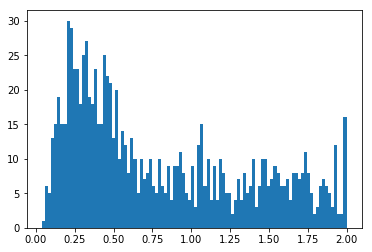

In [40]:
%pylab inline
plt.hist(lst,bins=100);
print np.mean(lst) 

13.0 12.7724 0.327877


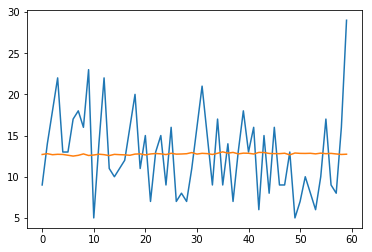

In [42]:
i=1233
u=Y[i][:60]
v=a[i]
plt.plot(u)
plt.plot(v)
print np.median(u),np.median(v), (2*np.abs(u-v)/(np.abs(u)+np.abs(v))).mean()

In [43]:
daily_data.shape,attrib_data.shape

((145063, 256), (145063, 12))

In [44]:
daily_test=daily_data[:,-LEN1:]
attrib_test=attrib_data
daily_test.shape,attrib_test.shape

((145063, 128), (145063, 12))

In [45]:
feed_dict={x:daily_test,x2:attrib_test}
predTest=sess.run(prediction,feed_dict=feed_dict)
predTest.shape

(145063, 60)

In [46]:
predTest=np.round(predTest,1)
np.mean(predTest<1)

1.3787113185305695e-05

In [47]:
import datetime
cols=pd.date_range(pd.datetime.date(datetime.datetime(2017, 1, 1)), periods=60).map(lambda u: u.strftime("%Y-%m-%d"))
idx=pd.read_csv("../input/train_1.csv",usecols=[0])["Page"]
idx.shape

(145063,)

In [48]:
submission=pd.DataFrame(predTest,columns=cols,index=idx)
submission=submission.unstack().reset_index()
submission['name']=submission.apply(lambda r: r['Page']+"_"+r['level_0'],axis=1)
submission=submission.drop(['Page','level_0'],axis=1)
submission.columns=['Visits','name']

In [49]:
submission=submission[["name",'Visits']]
submission.head()

name     Visits
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.700001
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  21.299999
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.600000
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.800000
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.200000

In [50]:
keys=pd.read_csv("../input/key_1.csv",index_col=0)

In [51]:
keys_dict=keys["Id"].to_dict()

In [52]:
submission["Id"]=submission["name"].apply(lambda u:keys_dict[u])

In [53]:
submission.isnull().sum().sum()

0L

In [54]:
submission.head()

name     Visits            Id
0  2NE1_zh.wikipedia.org_all-access_spider_2017-0...  19.700001  ff8c1aade3de
1  2PM_zh.wikipedia.org_all-access_spider_2017-01-01  21.299999  3da6fd5b23c1
2   3C_zh.wikipedia.org_all-access_spider_2017-01-01   4.600000  cd9e83803be4
3  4minute_zh.wikipedia.org_all-access_spider_201...  13.800000  65cd4af0968c
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  10.200000  75bae1fb2637

In [55]:
submission[["Id","Visits"]].to_csv("../submission/sub_pred_lstm1_60_512_256d_nozero.csv.gz",
                                   index=None, float_format='%.1f', compression="gzip")